In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pearsonr, zscore
from scipy.spatial.distance import squareform
import scipy.io
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy import stats
import sys
from matplotlib.backends.backend_pdf import PdfPages

file_path = os.getcwd()
file_path = file_path.split('/')
root_path = '/'.join(file_path[:-2]) + '/'
# root_path = '/home/dayoung/dFC/RL/'
sys.path.append(os.path.join(root_path, 'tools'))

from isc_standalone import isc 

K = 4
delta = 0.3
iter_tmp = 5

glmm_data = scipy.io.loadmat(os.path.join(root_path,'results','glmm','glmm_k'+str(K)+'_'+str(delta)+'.mat'))
mus_iter = glmm_data['mus_iter']  # (147, 4, 6)
mus = np.squeeze(mus_iter[:,:,iter_tmp-1]) # (147, 4)
Nnodes = mus.shape[0]

n_net = 7
net_data = scipy.io.loadmat(os.path.join(root_path,'data','shaefer100_subcortex_' + str(n_net) + 'system.mat'))
lab = net_data['lab']
if n_net == 7:
    net = ['VIS','SOM','DAN', 'VAN', 'LIM', 'FPN', 'DMN', 'SC']
elif n_net == 17:
    net = ['VISCent', 'VISPer', 'SOMa','SOMb', 'DATa', 'DATb', 'VATa', 'VATb', 'LIMa', 'LIMb', 'ContA', 'ContB', 'ContC', 'DMNa', 'DMNb', 'DMNc', 'TP', 'SC']

labs = np.ones((Nnodes,1)) * (n_net+1)
labs[:len(lab)] = lab  # labs[99] = 7, 1abs[100] = 8 이어야 함.
nets = list()
for ii in range(Nnodes):
    nets.append(net[int(labs[ii]-1)])

/tmp/ipykernel_10473/1820122089.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nets.append(net[int(labs[ii]-1)])


#### Violinplots of Fig. 3a Results of GLMM analysis

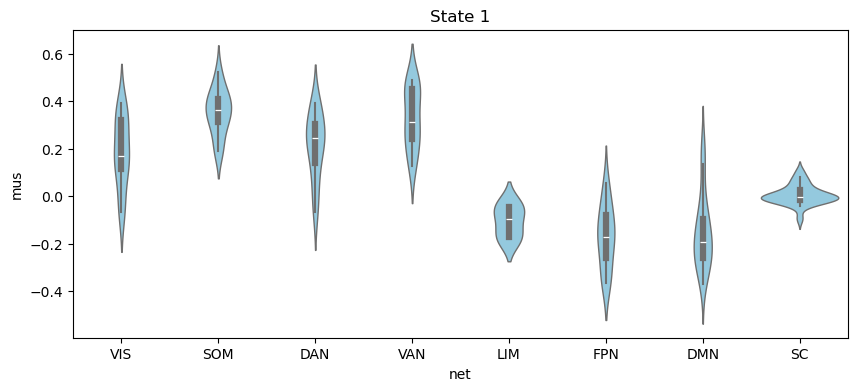

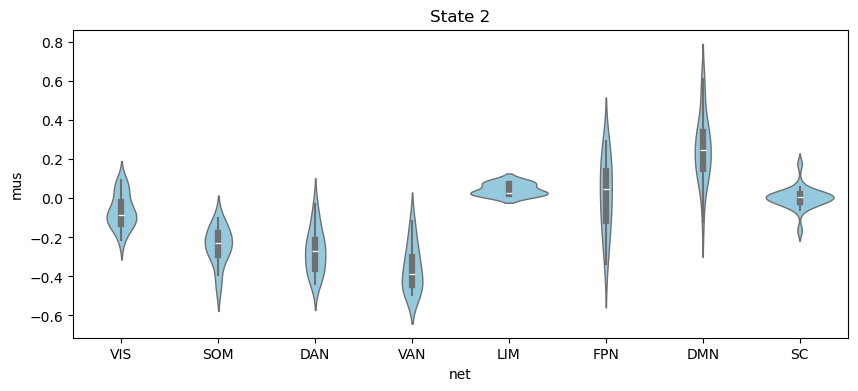

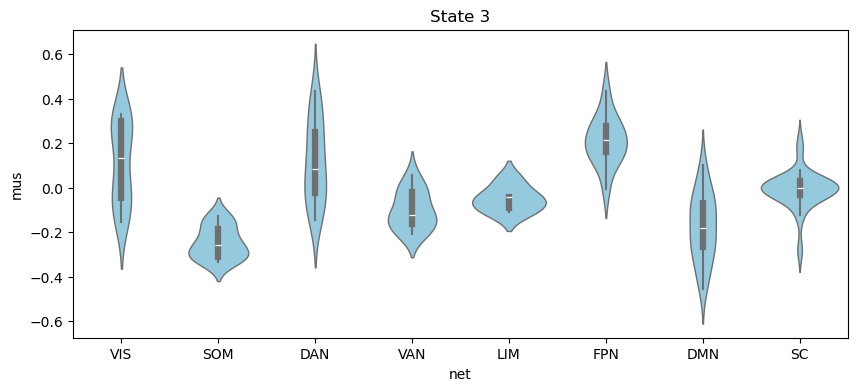

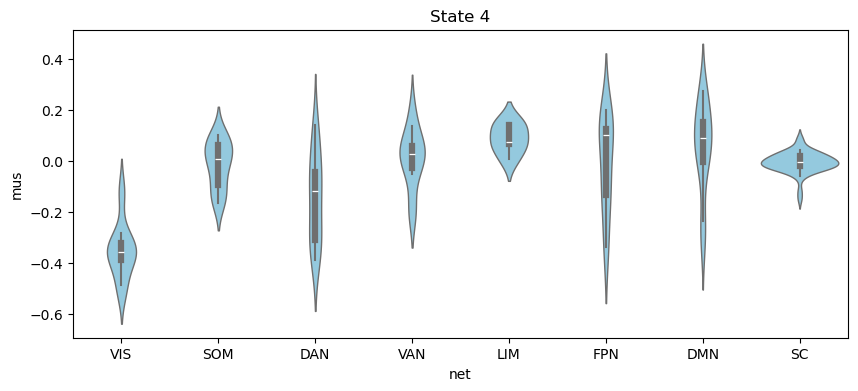

In [3]:
for ki in range(K):
    plt.figure(figsize = (10, 4))
    plt.title('State {}'.format(ki+1))
    mus_tmp = mus[:,ki] # (147, )
    plot_data = {'mus' : mus_tmp, 'net' : nets}
    plot_data = pd.DataFrame(plot_data)
    sns.violinplot(data=plot_data, x='net', y='mus', color='skyblue', linewidth=1)
    plt.show()

##### Fig. 6a recruit_integration matrix of each state

In [ ]:
state_int_rec = scipy.io.loadmat(os.path.join(root_path, 'data', 'state_int_rec.mat')) 
inter_whole = state_int_rec['inter_whole']  # (7, 7, 4)
I_max = state_int_rec['I_max']  # (7, 7)
I_min = state_int_rec['I_min']  # (7, 7)
print(inter_whole.shape)
print(I_max.shape)
K = inter_whole.shape[2]
Nnet = inter_whole.shape[0]

cbar_max_inter = np.zeros((K,1))
cbar_min_inter = np.zeros((K,1))
cbar_max_intra = np.zeros((K,1))
cbar_min_intra = np.zeros((K,1))
for ki in range(K):
    plot_data = np.squeeze(inter_whole[:,:,ki])
    diag_tmp = np.eye(7, 7) * np.sum(np.triu(plot_data, 1))/np.where(np.triu(plot_data, 1))[0].shape[0]
    plot_data_inter = diag_tmp + np.triu(plot_data, 1) + np.tril(plot_data, -1)
    diag_tmp = np.eye(7, 7) * np.diag(plot_data)
    plot_data_intra = diag_tmp + (np.ones(7) - np.eye(7, 7)) * np.mean(np.diag(plot_data))
    cbar_max_intra[ki] = np.max(plot_data_intra)
    cbar_min_intra[ki] = np.min(plot_data_intra)
    cbar_max_inter[ki] = np.max(plot_data_inter)
    cbar_min_inter[ki] = np.min(plot_data_inter)    

mask = np.zeros_like(I_max, dtype=bool)
mask[np.diag_indices_from(mask)] = True
for ki in range(K):
    plot_data = np.squeeze(inter_whole[:,:,ki])
    diag_tmp = np.eye(7, 7) * np.sum(np.tril(plot_data, -1))/np.where(np.tril(plot_data, -1))[0].shape[0]
    plot_data_inter = diag_tmp + np.tril(plot_data, -1) + np.triu(plot_data, 1)
    
    globals()['fig_state' + str(ki+1)], ax = plt.subplots(figsize=(6, 4.3), constrained_layout=True)
    sns.heatmap(data=plot_data_inter, mask=mask, cmap="YlOrBr", annot = False, fmt="", 
                    annot_kws={'size':30, 'color':'red', 'fontweight':'bold'}, linewidths=.5, cbar=False, ax=ax, 
                    xticklabels=net[0:7], yticklabels=net[0:7], vmin=np.min(cbar_min_inter), vmax=np.min(cbar_max_inter))
    diag_tmp = np.eye(7, 7) * np.diag(plot_data)
    plot_data_intra = diag_tmp + (np.ones(7) - np.eye(7, 7)) * np.mean(np.diag(plot_data))
    sns.heatmap(data=plot_data_intra, mask=~mask, cmap="Greens", annot = False, fmt="", 
                annot_kws={'size':30, 'fontweight':'bold'}, linewidths=.5, cbar=False, ax=ax, xticklabels=net[0:7], yticklabels=net[0:7], 
                vmin=np.min(cbar_min_intra), vmax=np.min(cbar_max_intra))

    annot_max = np.where(I_max == (ki+1))
    annot_min = np.where(I_min == (ki+1))
    
    for ii in range(len(annot_max[0])):
        i = annot_max[0][ii]
        j = annot_max[1][ii]
        if j <= i:
            plt.annotate('', xytext=(i+0.5, j+0.75), xy=(i+0.5, j+0.75-0.6), xycoords='data', arrowprops={'arrowstyle':'simple', 'facecolor':'red', 'linewidth':1})
    for ii in range(len(annot_min[0])):
        i = annot_min[0][ii]
        j = annot_min[1][ii]            
        if j >= i:
            plt.annotate('', xytext=(i+0.5, j+0.75-0.6), xy=(i+0.5, j+0.75), xycoords='data', arrowprops={'arrowstyle':'simple', 'facecolor':'blue', 'linewidth':1})
    # add colorbar
    cbar1 = ax.figure.colorbar(ax.collections[0], ax=ax, orientation="vertical", pad=0.05)
    cbar2 = ax.figure.colorbar(ax.collections[1], ax=ax, orientation="vertical", pad=0.1)
    plt.title('State '+str(ki + 1))
pdf_file_path = os.path.join(root_path,'results','Figures','int_rec_state.pdf')
with PdfPages(pdf_file_path) as pdf:
        for ki in range(K):
            pdf.savefig(globals()['fig_state' + str(ki+1)])

#### Fig. 4a, b : line plot of state activation and dISC of state

(54, 4, 210)
(210, 4, 54)


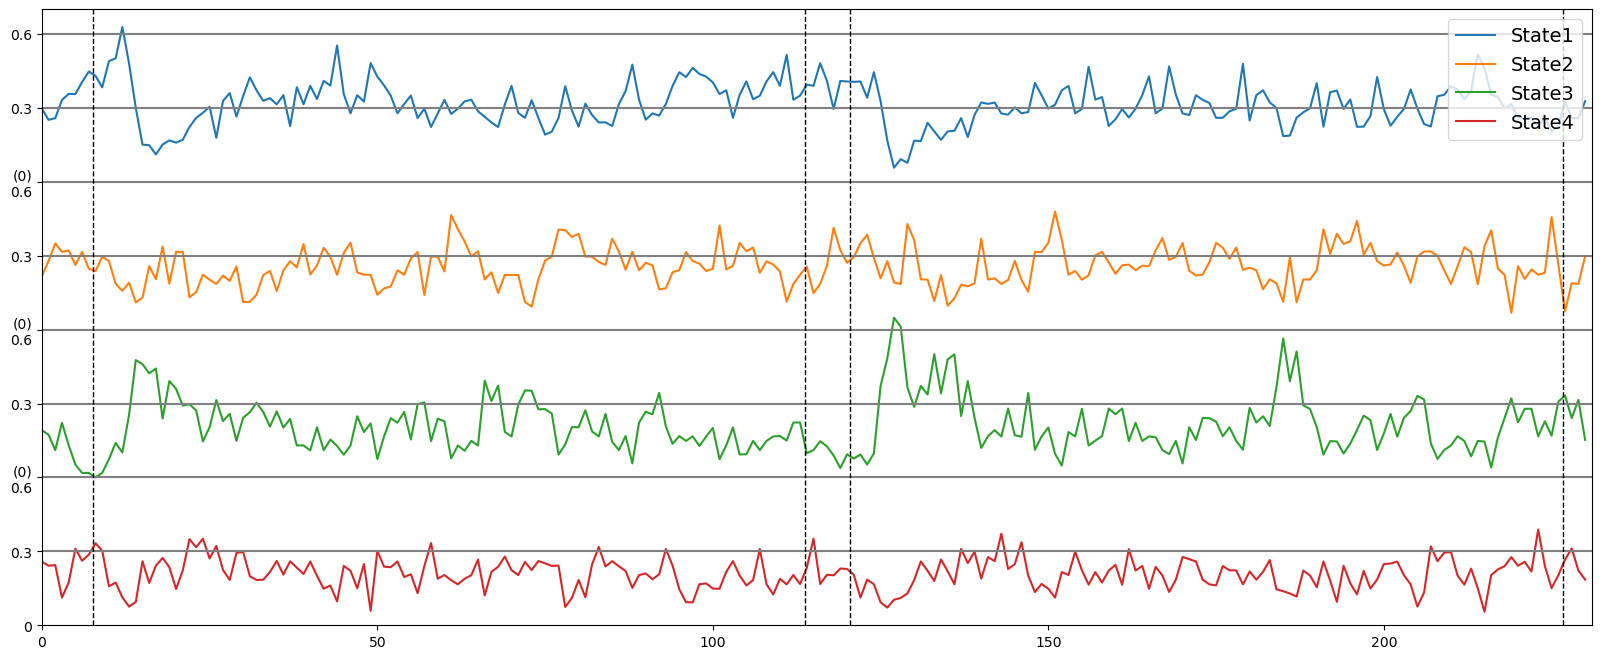

In [58]:
gamma_hats_iter = glmm_data['gamma_hats_iter']
gamma_hats = np.squeeze(gamma_hats_iter[:,:,iter_tmp-1])
Nsubj = 54
TR = 1.5
window_len = 21
tp = int(gamma_hats.shape[0]/Nsubj)

x = np.linspace(0, tp-1, tp)  # 0 ~ 230
xq = np.linspace(x.min(), x.max(), int(tp * TR * 10))
x_window = np.linspace(0, int(tp-window_len-1), int(tp-window_len))
xq_window = np.linspace(x_window.min(), x_window.max(), int((tp-window_len) * TR * 10))

gamma_hats_tmp = np.reshape(gamma_hats, [Nsubj, tp, K])
gamma_hats_tmp = np.moveaxis(gamma_hats_tmp, 0, 2)  # [tp, K, Nsubj]
window_iscs_state_loo = np.empty([Nsubj,K])
for ti in range(tp - window_len):
    window_data = gamma_hats_tmp[ti:(ti + window_len),...]
    tmp_window_iscs_state_loo = isc(window_data, pairwise=False)  # [54(Nsubj) x 4(states)]
    window_iscs_state_loo = np.dstack([window_iscs_state_loo, tmp_window_iscs_state_loo])

window_iscs_state_loo = window_iscs_state_loo[:,:,1:]
print(np.shape(window_iscs_state_loo))  # [54(Nsubj) x 4(states) x 210(tp-window_len)]
window_iscs_state_loo = np.swapaxes(window_iscs_state_loo, 0, 2)  
print(np.shape(window_iscs_state_loo)) # [210(tp-window_len) x 4(states) x 54(Nsubj) ]

mean_state_ACT = np.mean(gamma_hats_tmp, 2)
mean_state_dISC = np.mean(window_iscs_state_loo, 2)

## ACT
term = 0.6
fig = plt.figure(figsize=(20, 8))
labels = list()
yticks = list()
yticklabels = list()
for ki in range(K):
    plt.plot(mean_state_ACT[:,ki] - term * ki)
    labels.append('State'+str(ki+1))
    yticks.extend([i - (term * ki) for i in [0.6, 0.3]])
    yticklabels.extend([0.6, 0.3])
yticks.append(-term * (K-1))
yticklabels.append(0)
yticklabels[2] = '(0)\n0.6'
yticklabels[4] = '(0)\n0.6'
yticklabels[6] = '(0)\n0.6'
plt.legend(labels, loc = 'upper right', fontsize = 14)
for ki in range(K):
    plt.axhline(0.3 - term * ki, color='gray')
    plt.axhline(0.6 - term * ki, color='gray')
plt.axvline(x=xq[int(7*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=1)
plt.axvline(x=xq[int(114*TR*10 + 5 - 1)], color='k', linestyle='--', linewidth=1)
plt.axvline(x=xq[int(121*TR*10 - 1)], color='k', linestyle='--', linewidth=1)
plt.axvline(x=xq[int(227*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=1)
'''
plt.annotate('', xytext = (14, 0.58), xy=(17, 0.2), arrowprops=dict(facecolor='k', edgecolor='k'))
plt.annotate('', xytext = (9, -1.05), xy=(12.5, -0.75), arrowprops=dict(facecolor='k', edgecolor='k'))
plt.annotate('', xytext = (16 + 110, 0.38), xy=(18 + 110, 0.1), arrowprops=dict(facecolor='k', edgecolor='k'))
plt.annotate('', xytext = (10 + 110, -1.05), xy=(13 + 110, -0.75), arrowprops=dict(facecolor='k', edgecolor='k'))

plt.annotate('', xytext = (73, -0.1), xy=(70, -0.3), arrowprops=dict(facecolor='gray', edgecolor='gray'))
plt.annotate('', xytext = (73, -0.1-0.5), xy=(70, -0.3-0.5), arrowprops=dict(facecolor='gray', edgecolor='gray'))
plt.annotate('', xytext = (189, -0.05), xy=(187, -0.25), arrowprops=dict(facecolor='gray', edgecolor='gray'))
plt.annotate('', xytext = (191, -0.1-0.5), xy=(188, -0.3-0.4), arrowprops=dict(facecolor='gray', edgecolor='gray'))
'''
plt.xlim([0, tp])
plt.yticks(yticks, labels=yticklabels)
plt.ylim([min(yticks), 0.7])

pdf_file_path = os.path.join(root_path,'results','Figures','fig4a.pdf')
with PdfPages(pdf_file_path) as pdf:
    pdf.savefig(fig)

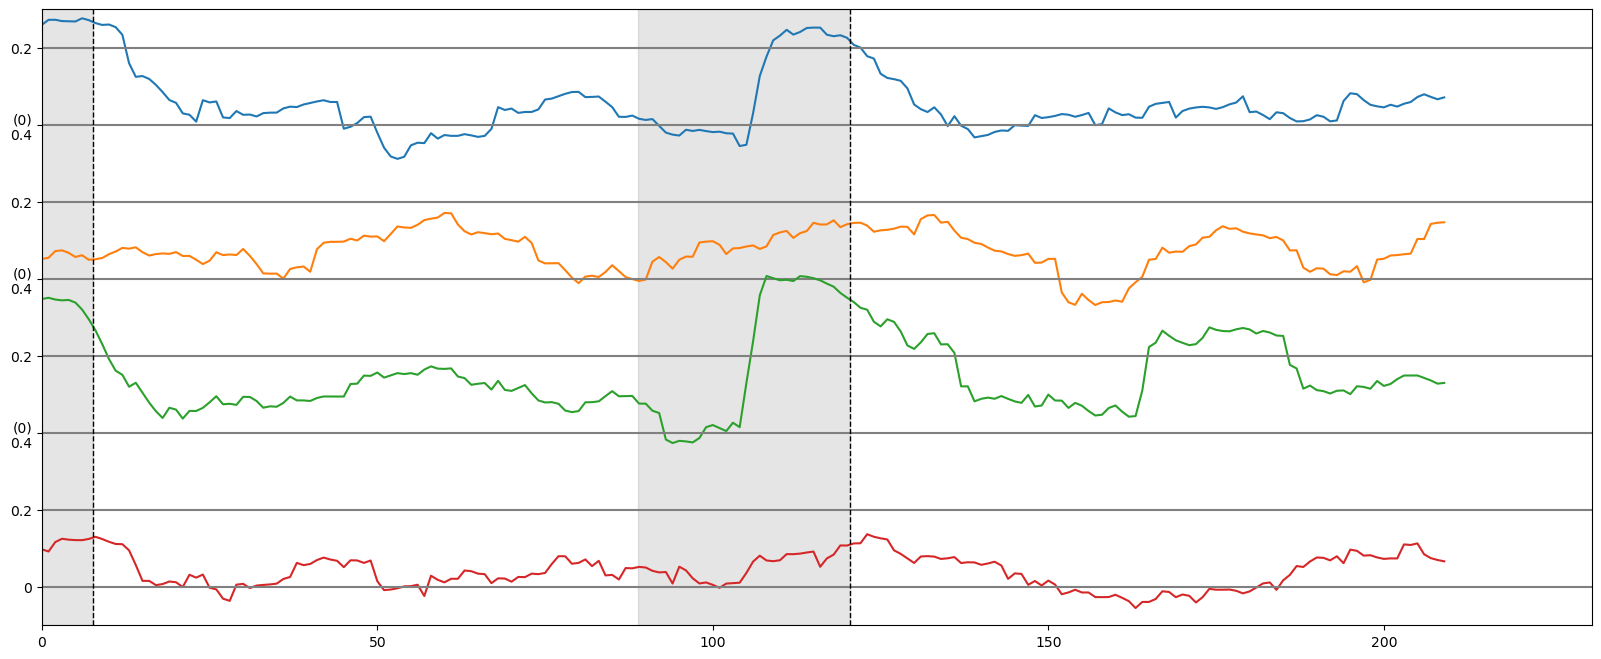

In [59]:
## dISC
fig = plt.figure(figsize=(20, 8))
yticks = list()
yticklabels = list()
term = 0.4
for ki in range(K):
    plt.plot(mean_state_dISC[:,ki] - term * ki)
    plt.axhline(0.2 - term * ki, color='gray')
    plt.axhline(0 - term * ki, color='gray')
    yticks.extend([i - (term * ki) for i in [0.2, 0]])
    yticklabels.extend([0.2, 0])
yticklabels[1] = '(0)\n0.4'
yticklabels[3] = '(0)\n0.4'
yticklabels[5] = '(0)\n0.4'
plt.axvline(x=xq_window[int(7*TR*10 + 10 - 1)], color='k', linestyle='--', linewidth=1)
plt.fill_between([0, xq_window[int(7*TR*10 + 10 - 1)]], [0.3, 0.3], [min(yticks)-0.1, min(yticks)-0.1], color = 'k', alpha = 0.1)
plt.axvline(x=xq_window[int(121*TR*10 - 1)], color='k', linestyle='--', linewidth=1)
#plt.fill_between([xq_window[int(121*TR*10 - 1)] - window_len, xq_window[int(121*TR*10 - 1)] + window_len], [1.1, 1.1], color = 'k', alpha = 0.1)
plt.fill_between([xq_window[int(121*TR*10 - 1)] - window_len*TR, xq_window[int(121*TR*10 - 1)]], [0.3, 0.3], [min(yticks)-0.1, min(yticks)-0.1], color = 'k', alpha = 0.1)
'''
plt.annotate('', xytext = (18, 0.28), xy=(17, 0.2), arrowprops=dict(facecolor='k', edgecolor='k'))
plt.annotate('', xytext = (18, 0.3-0.8), xy=(17, 0.2-0.8), arrowprops=dict(facecolor='k', edgecolor='k'))
plt.annotate('', xytext = (20 + 110, 0.28), xy=(18 + 110, 0.15), arrowprops=dict(facecolor='k', edgecolor='k'))
plt.annotate('', xytext = (20 + 110, 0.3-0.65), xy=(18 + 110, 0.2-0.65), arrowprops=dict(facecolor='k', edgecolor='k'))

plt.annotate('', xytext = (70, -0.15), xy=(65, -0.25), arrowprops=dict(facecolor='gray', edgecolor='gray'))
plt.annotate('', xytext = (70, -0.15-0.4), xy=(65, -0.25-0.4), arrowprops=dict(facecolor='gray', edgecolor='gray'))
plt.annotate('', xytext = (70+ 115, -0.15), xy=(65+ 115, -0.25), arrowprops=dict(facecolor='gray', edgecolor='gray'))
plt.annotate('', xytext = (70+ 115, -0.15-0.25), xy=(65+ 115, -0.25-0.25), arrowprops=dict(facecolor='gray', edgecolor='gray'))
'''
plt.xlim([0, tp])
plt.yticks(yticks, labels=yticklabels)
plt.ylim([min(yticks)-0.1, 0.3])
# plt.legend(labels, loc = 'upper right', fontsize = 16)

pdf_file_path = os.path.join(root_path,'results','Figures','fig4b.pdf')
with PdfPages(pdf_file_path) as pdf:
    pdf.savefig(fig)

#### Fig. 4d, e: Permutation results

State 1 : pval = 0.0
State 2 : pval = 0.0
State 3 : pval = 0.0
State 4 : pval = 0.004


"\npdf_file_path = os.path.join(root_path,'results','Figures','fig4d.pdf')\nwith PdfPages(pdf_file_path) as pdf:\n    for ki in range(K):\n        pdf.savefig(globals()['fig'+str(ki)])\n"

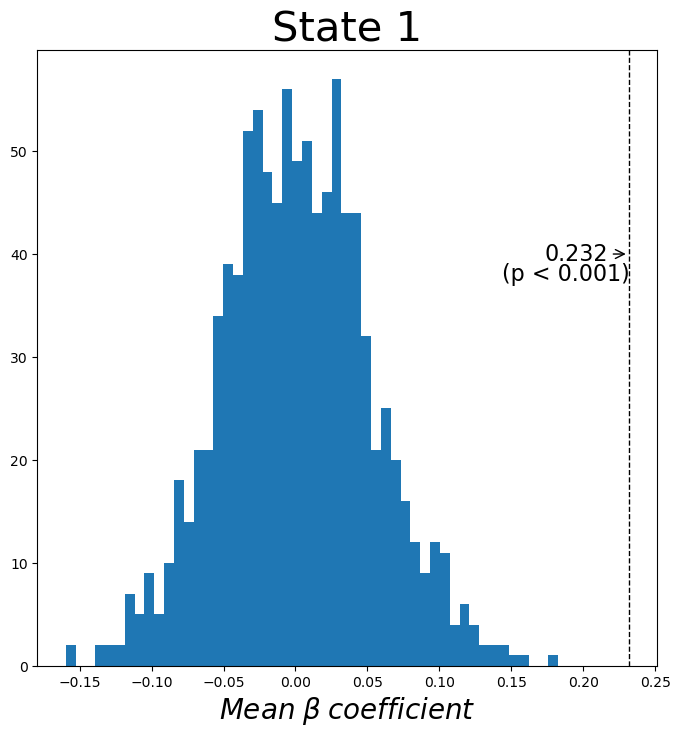

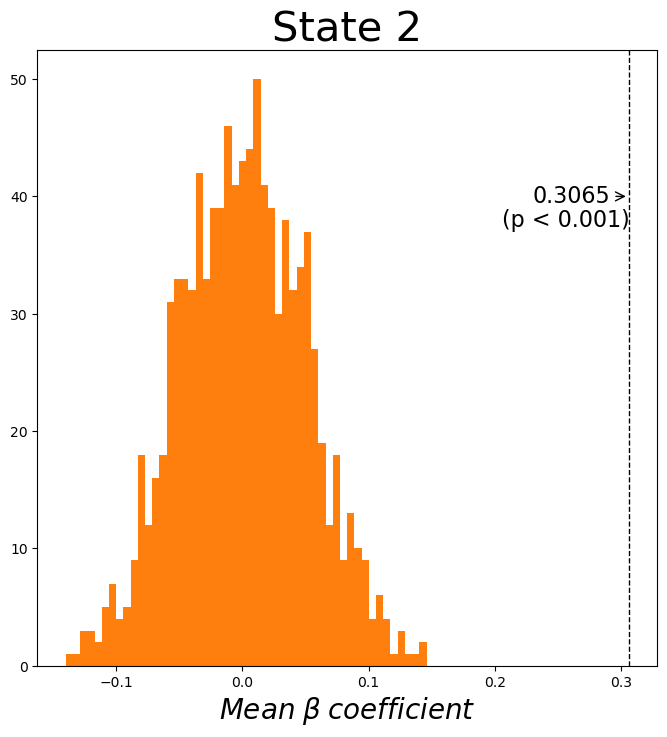

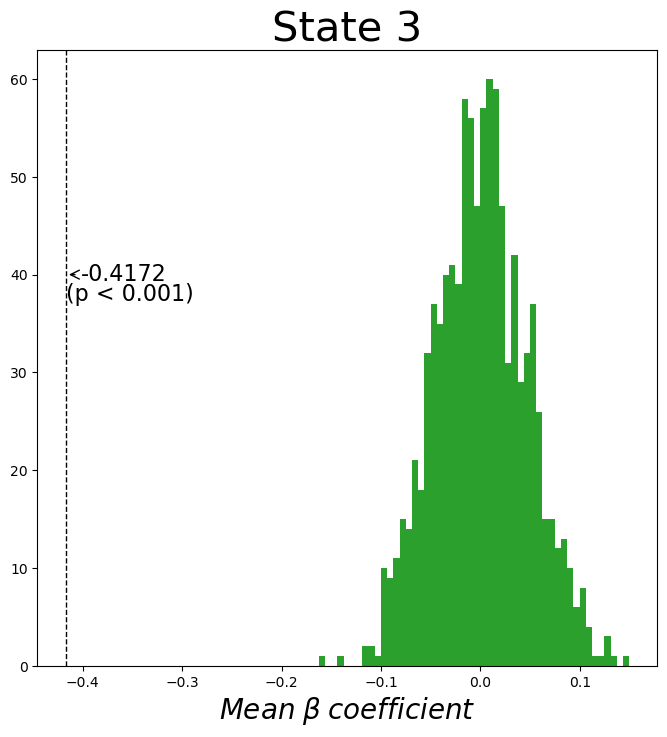

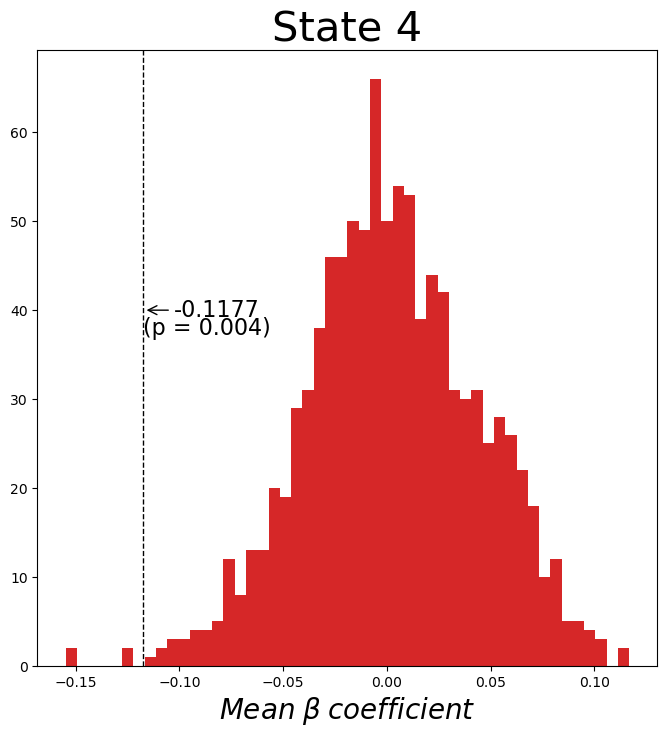

In [105]:
# Fig. 4d
color_seq = ['tab:blue','tab:orange','tab:green','tab:red']

model_idx = 1
var_idx = -1

state_GLM_act = scipy.io.loadmat(os.path.join(root_path,'results', 'GLM', 'act_state_DS'+'{0:02d}'.format(model_idx)+'.mat'))
state_GLM_act = state_GLM_act['params_mass'] # (4, 54, 2)
null_state_GLM_act = scipy.io.loadmat(os.path.join(root_path,'results', 'GLM', 'null_act_state_DS'+'{0:02d}'.format(model_idx)+'.mat'))
null_state_GLM_act = null_state_GLM_act['params_mass'] # (4, 54, 2, 1000)

state_GLM_act_var = np.squeeze(state_GLM_act[:,:,var_idx])  # (4, 54)
null_state_GLM_act_var = np.squeeze(null_state_GLM_act[:,:,var_idx])  # (4, 54, 1000)
iter_num = null_state_GLM_act_var.shape[2]

mean_beta_coef = np.mean(state_GLM_act_var, axis = 1)
for ki in range(K):
    globals()['fig'+str(ki)] = plt.figure(figsize=(8, 8))
    mean_null_state_GLM_act_var = np.mean(null_state_GLM_act_var[ki,:,:], axis = 0)
    pval = np.round(len(np.where(mean_null_state_GLM_act_var <= mean_beta_coef[ki])[0])/iter_num, 5)
    if pval > 0.5:
        pval = np.round(1 - pval, 5)
    if pval < 0.001:
        pval_str = '(p < 0.001)'
    else:
        pval_str = '(p = '+str(pval)+')'
    print('State '+str(ki + 1)+' : pval = '+str(pval))
    plt.hist(mean_null_state_GLM_act_var, bins=50, rwidth=1, color = color_seq[ki])
    plt.axvline(x = mean_beta_coef[ki], color='black', lw=1, linestyle='--')
    plt.xlabel(r'$Mean \; \beta \; coefficient$', fontsize=20)
    if mean_beta_coef[ki] > 0:
        if np.max(mean_beta_coef[ki]) - np.min(mean_beta_coef[ki]) > 0.1 :
            plt.annotate(str(np.round(mean_beta_coef[ki],4)), xytext=(mean_beta_coef[ki]-0.145, 50), xy=(mean_beta_coef[ki]-0.001, 50), xycoords='data', 
                arrowprops=dict(arrowstyle='->', color='k', lw=1), va='center', ha = 'right', fontsize = 16)
            plt.annotate(pval_str, xy=(mean_beta_coef[ki]-0.035, 48), ha='center', va='center', fontsize = 16)
        else:
            plt.annotate(str(np.round(mean_beta_coef[ki],4)), xytext=(mean_beta_coef[ki]-0.015, 40), xy=(mean_beta_coef[ki]-0.0005, 40), xycoords='data', 
                arrowprops=dict(arrowstyle='->', color='k', lw=1), va='center', ha = 'right', fontsize = 16)
            plt.annotate(pval_str, xy=(mean_beta_coef[ki], 38), ha='right', va='center', fontsize = 16)
    else:
        if np.max(mean_beta_coef[ki]) - np.min(mean_beta_coef[ki]) > 0.1 :
            plt.annotate(str(np.round(mean_beta_coef[ki],4)), xytext=(mean_beta_coef[ki]+0.13, 50), xy=(mean_beta_coef[ki]+0.001, 50), xycoords='data', 
                arrowprops=dict(arrowstyle='->', color='k', lw=1), va='center', ha = 'left', fontsize = 16)
            plt.annotate(pval_str, xy=(mean_beta_coef[ki], 48), ha='left', va='center', fontsize = 16)
        else:
            plt.annotate(str(np.round(mean_beta_coef[ki],4)), xytext=(mean_beta_coef[ki]+0.015, 40), xy=(mean_beta_coef[ki]+0.0005, 40), xycoords='data', 
                arrowprops=dict(arrowstyle='->', color='k', lw=1), va='center', ha = 'left', fontsize = 16)
            plt.annotate(pval_str, xy=(mean_beta_coef[ki], 38), ha='left', va='center', fontsize = 16)
    plt.title('State ' + str(ki + 1), fontsize = 30)
'''
pdf_file_path = os.path.join(root_path,'results','Figures','fig4d.pdf')
with PdfPages(pdf_file_path) as pdf:
    for ki in range(K):
        pdf.savefig(globals()['fig'+str(ki)])
'''  

"\npdf_file_path = os.path.join(root_path,'results', 'Figures', 'fig4e.pdf')\nwith PdfPages(pdf_file_path) as pdf:\n    for ki in range(K):\n        pdf.savefig(globals()['fig'+str(ki)])\n"

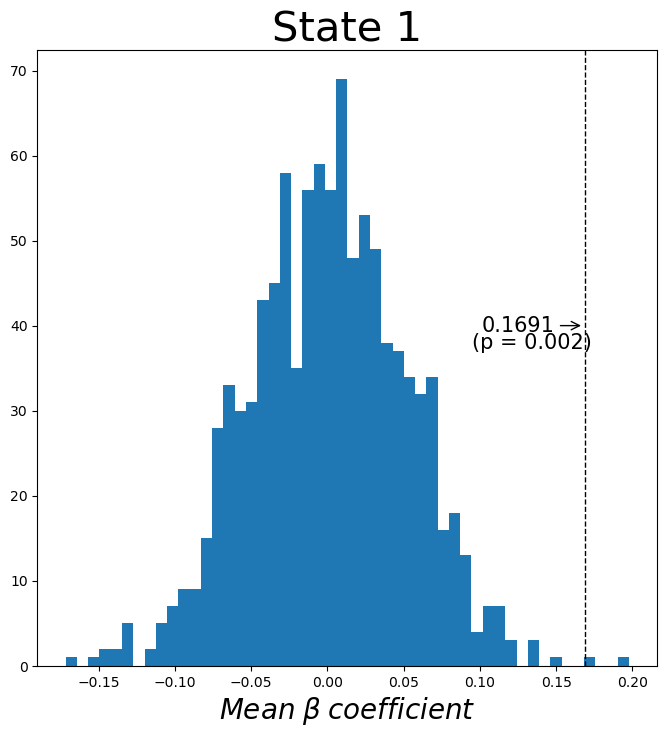

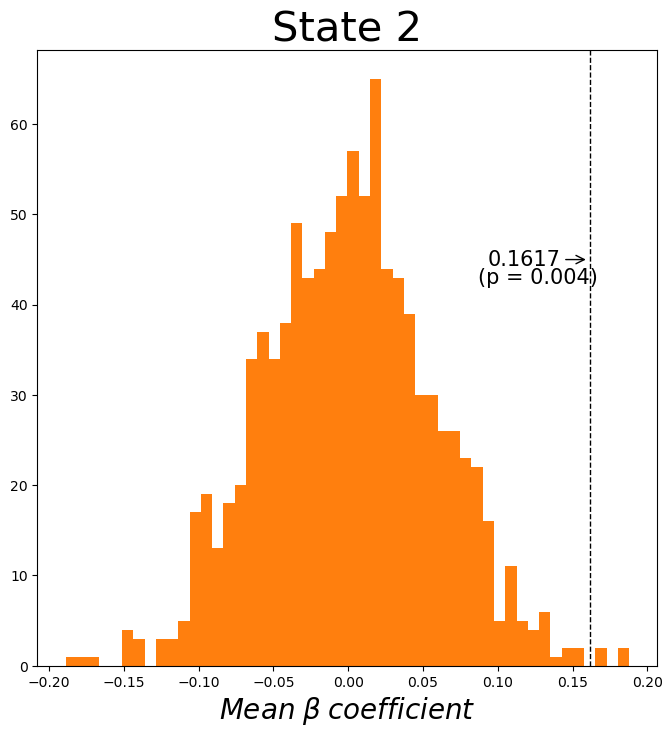

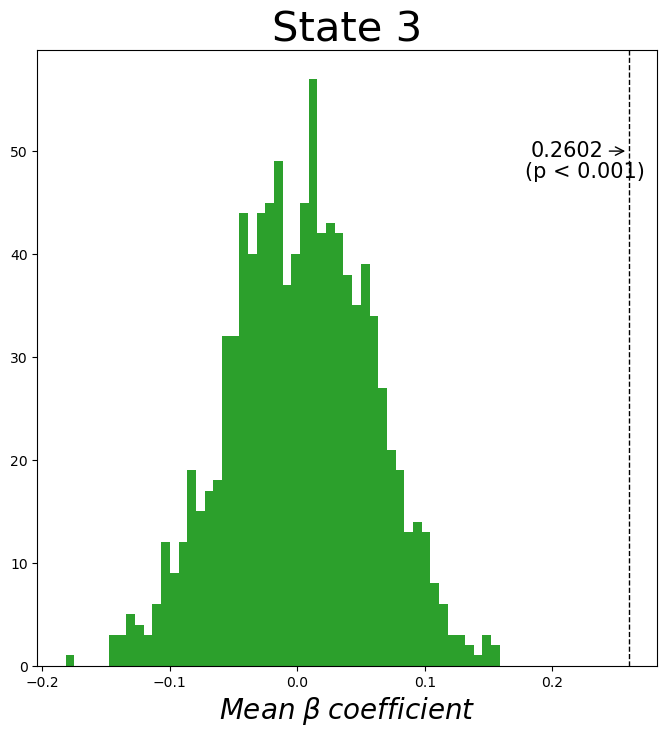

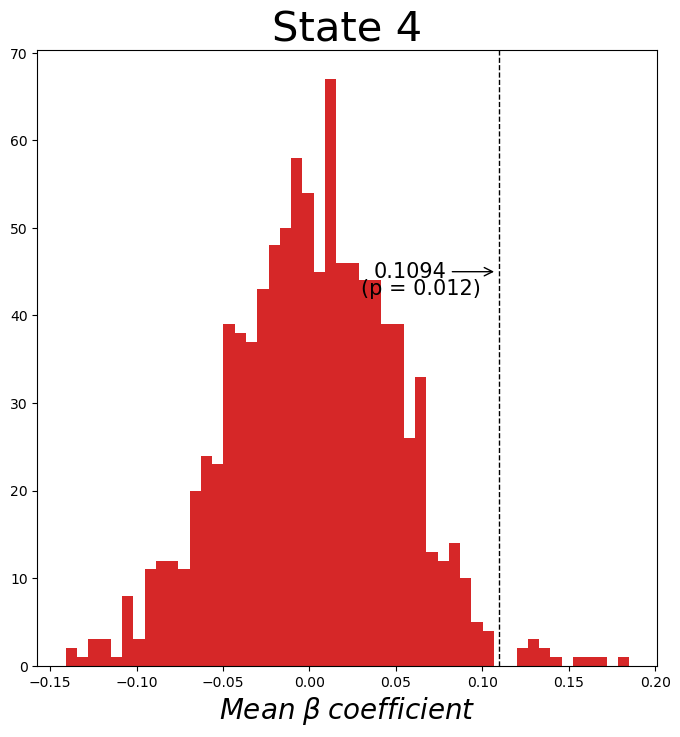

In [112]:
# Fig. 4e
model_idx = 12
var_idx = -1

state_GLM_dISC = scipy.io.loadmat(os.path.join(root_path + 'results', 'GLM', 'dISC_state_DS'+'{0:02d}'.format(model_idx)+'.mat'))
state_GLM_dISC = state_GLM_dISC['params_mass'] # (4, 54, 2)
null_state_GLM_dISC = scipy.io.loadmat(os.path.join(root_path,'results','GLM','null_dISC_state_DS'+'{0:02d}'.format(model_idx)+'.mat'))
null_state_GLM_dISC = null_state_GLM_dISC['params_mass'] # (4, 54, 2, 1000)

state_GLM_dISC_prec = np.squeeze(state_GLM_dISC[:,:,var_idx])  # (4, 54)
null_state_GLM_dISC_prec = np.squeeze(null_state_GLM_dISC[:,:,var_idx])  # (4, 54, 1000)
iter_num = null_state_GLM_dISC_prec.shape[2]

mean_beta_coef = np.mean(state_GLM_dISC_prec, axis = 1)
y_seq = [40, 45, 50, 45]
for ki in range(K):
    globals()['fig'+str(ki)] = plt.figure(figsize=(8, 8))
    mean_null_state_GLM_dISC_prec = np.mean(null_state_GLM_dISC_prec[ki,:,:], axis = 0)
    pval = np.round(len(np.where(mean_null_state_GLM_dISC_prec <= mean_beta_coef[ki])[0])/iter_num, 5)
    if pval > 0.5:
        pval = np.round(1 - pval, 5)
    if pval < 0.001:
        pval_str = '(p < 0.001)'
    else:
        pval_str = '(p = '+str(pval)+')'
    plt.hist(mean_null_state_GLM_dISC_prec, bins=50, rwidth=1, color = color_seq[ki])
    plt.axvline(x = mean_beta_coef[ki], color='black', lw=1, linestyle='--')
    plt.xlabel(r'$Mean \; \beta \; coefficient$', fontsize=20)    
    if ki == 3:
        plt.annotate(str(np.round(mean_beta_coef[ki],4)), xytext=(mean_beta_coef[ki]-0.03, y_seq[ki]), xy=(mean_beta_coef[ki]-0.001, y_seq[ki]), xycoords='data', 
            arrowprops=dict(arrowstyle='->', color='k', lw=1), va='center', ha = 'right', fontsize = 15)
        plt.annotate(pval_str, xy=(mean_beta_coef[ki]-0.045, y_seq[ki]-2), ha='center', va='center', fontsize = 15)
    else:
        plt.annotate(str(np.round(mean_beta_coef[ki],4)), xytext=(mean_beta_coef[ki]-0.02, y_seq[ki]), xy=(mean_beta_coef[ki]-0.001, y_seq[ki]), xycoords='data', 
            arrowprops=dict(arrowstyle='->', color='k', lw=1), va='center', ha = 'right', fontsize = 15)
        plt.annotate(pval_str, xy=(mean_beta_coef[ki]-0.035, y_seq[ki]-2), ha='center', va='center', fontsize = 15)
    plt.title('State ' + str(ki + 1), fontsize = 30)

'''
pdf_file_path = os.path.join(root_path,'results', 'Figures', 'fig4e.pdf')
with PdfPages(pdf_file_path) as pdf:
    for ki in range(K):
        pdf.savefig(globals()['fig'+str(ki)])
'''

##### Fig. 5 : the average number of each type of feedback and the association with precision. 

In [8]:
data_path = os.path.join(root_path,'data','behav')
tmp1 = scipy.io.loadmat(os.path.join(data_path,'feedtype_ts.mat'))   # 'loss_ts', 'reward_ts'
tmp2 = scipy.io.loadmat(os.path.join(data_path,'feedback_4type.mat')) # 'prec_4types_lose', 'prec_4types_rew', 'mean_prec_4types_lose', 'mean_prec_4types_rew'

loss_ts = tmp1['loss_ts']  # (40, 4)
reward_ts = tmp1['reward_ts']

prec_4types_lose = tmp2['prec_4types_lose']  # (1, 4) cell type -> 각 셀은 각 타입에 해당하는 trial의 개수만큼의 길이의 배열
prec_4types_rew = tmp2['prec_4types_rew']

mean_prec_4types_lose = tmp2['mean_prec_4types_lose'] # (1, 4) cell type -> 각 셀은 54 x 1배열. 즉, prec_4types_lose의 각 셀의 한 피험자 당 평균을 계산 한 것. 
mean_prec_4types_lose = np.hstack([mean_prec_4types_lose[0,0],mean_prec_4types_lose[0,1],mean_prec_4types_lose[0,2],mean_prec_4types_lose[0,3]])
mean_prec_4types_lose[np.isnan(mean_prec_4types_lose)] = 0

mean_prec_4types_rew = tmp2['mean_prec_4types_rew']
mean_prec_4types_rew = np.hstack([mean_prec_4types_rew[0,0],mean_prec_4types_rew[0,1],mean_prec_4types_rew[0,2],mean_prec_4types_rew[0,3]])
mean_prec_4types_rew[np.isnan(mean_prec_4types_rew)] = 0

tmp_pall_1 = sns.color_palette("Blues")
tmp_pall_2 = sns.color_palette("Greens")

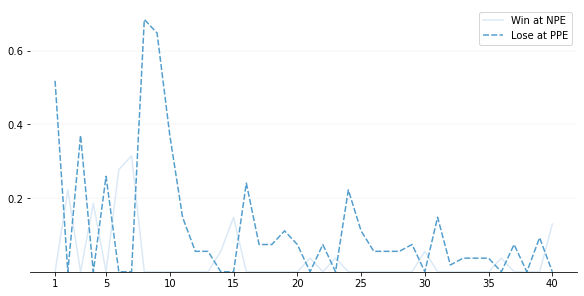

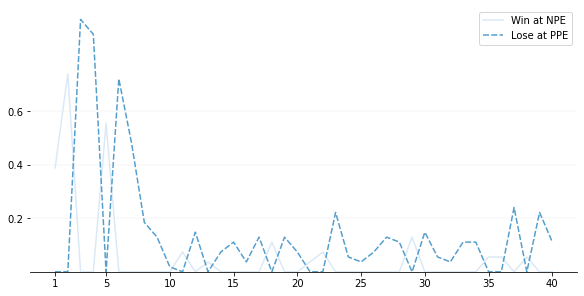

In [24]:
## Fig5.b
loss_ts_df = pd.DataFrame(loss_ts[:, 1:3])
loss_ts_df.columns = ['Win at NPE','Lose at PPE']
fig_loss, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
sns.lineplot(data = loss_ts_df, palette = [tmp_pall_1[0], tmp_pall_1[3]], ax = ax)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.set_xticks([0, 4, 9, 14, 19, 24, 29, 34, 39])
ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylim(0, )
ax.set_yticks([0.2, 0.4, 0.6])
#ax.set_yticklabels("")
ax.grid(axis="y", lw=0.1)

reward_ts_df = pd.DataFrame(reward_ts[:, 1:3])
reward_ts_df.columns = ['Win at NPE','Lose at PPE']
fig_reward, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
sns.lineplot(data = reward_ts_df, palette = [tmp_pall_1[0], tmp_pall_1[3]], ax = ax)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.set_xticks([0, 4, 9, 14, 19, 24, 29, 34, 39])
ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylim(0, )
ax.set_yticks([0.2, 0.4, 0.6])
#ax.set_yticklabels("")
ax.grid(axis="y", lw=0.1)
pdf_file_path = os.path.join(root_path,'results', 'Figures', 'fig5b.pdf')

with PdfPages(pdf_file_path) as pdf:
    pdf.savefig(fig_loss)
    pdf.savefig(fig_reward)

#### Fig. 5 b, c

/tmp/ipykernel_8577/3426596519.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['after uncertain feedback','after certain feedback'])
/tmp/ipykernel_8577/3426596519.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['after uncertain feedback','after certain feedback'])


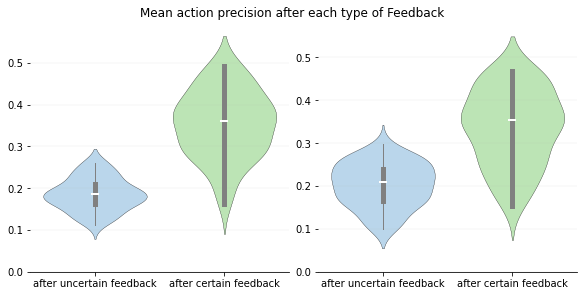

In [10]:
# Fig5c loss
mean_prec_2types_lose = scipy.io.loadmat(os.path.join(data_path,'feedback_2type.mat'))['mean_prec_2types_lose']
mean_prec_2types_rew = scipy.io.loadmat(os.path.join(data_path,'feedback_2type.mat'))['mean_prec_2types_rew']

mean_prec_2types_lose = np.hstack([mean_prec_2types_lose[0,0],mean_prec_2types_lose[0,1]])
mean_prec_2types_lose[np.isnan(mean_prec_2types_lose)] = 0
mean_prec_2types_rew = np.hstack([mean_prec_2types_rew[0,0],mean_prec_2types_rew[0,1]])
mean_prec_2types_rew[np.isnan(mean_prec_2types_rew)] = 0

inner_kws=dict(box_width=10, whis_width=1, color="grey")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
sns.violinplot(data=mean_prec_2types_lose, ax=ax1, linewidth=0.3, inner_kws=inner_kws) #, bw_adjest=.2, cut=0)

violins = [c for i, c in enumerate(ax1.collections)]  # 하나 건너 하나 있는 PolyCollection을 가져오기 위해 if i%2 == 0을 사용
[v.set_edgecolor("k") for v in violins]  # 전체 violin edgecolor 변경

violins[0].set_facecolor(tmp_pall_1[1])  
violins[1].set_facecolor(tmp_pall_2[1]) 

# box-whisker: Line2D
ls = [l for i, l in enumerate(ax1.lines)]
[l.set_linewidth(1) for i, l in enumerate(ls) if i%2 == 0] # 전체 box, whisher 굵기 변경
[l.set_linewidth(5) for i, l in enumerate(ls) if i%2 == 1] 

ax1.set_xticklabels(['after uncertain feedback','after certain feedback'])
#ax1.set_yticks([0, 0.6, 1.2, 1.8])
ax1.set_ylim(0, )
ax1.spines[["left", "top", "right"]].set_visible(False)
ax1.grid(axis="y", lw=0.1)
#ax1.set_title("Mean precision after each type of Feedback")

ax1.set_xlabel("")
ax1.set_ylabel("")

## Fig5c reward
#fig_reward, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
sns.violinplot(data=mean_prec_2types_rew, ax=ax2, linewidth=0.3, inner_kws=inner_kws)  #, bw_adjest=.2, cut=0)

violins = [c for i, c in enumerate(ax2.collections)]  # 하나 건너 하나 있는 PolyCollection을 가져오기 위해 if i%2 == 0을 사용
[v.set_edgecolor("k") for v in violins]  # 전체 violin edgecolor 변경

violins[0].set_facecolor(tmp_pall_1[1])  
violins[1].set_facecolor(tmp_pall_2[1]) 

# box-whisker: Line2D
ls = [l for i, l in enumerate(ax2.lines)]
[l.set_linewidth(1) for i, l in enumerate(ls) if i%2 == 0] # 전체 box, whisher 굵기 변경
[l.set_linewidth(5) for i, l in enumerate(ls) if i%2 == 1] 

ax2.set_xticklabels(['after uncertain feedback','after certain feedback'])
#ax2.set_yticks([0, 0.4, 0.8, 1.2])
ax2.set_ylim(0, )
ax2.spines[["left", "top", "right"]].set_visible(False)
ax2.grid(axis="y", lw=0.1)
#ax2.set_title("Mean precision after each type of Feedback")

ax2.set_xlabel("")
ax2.set_ylabel("")
fig.suptitle("Mean action precision after each type of Feedback")

pdf_file_path = os.path.join(root_path,'results', 'Figures', 'fig5c.pdf')
with PdfPages(pdf_file_path) as pdf:
    pdf.savefig(fig)
    #pdf.savefig(fig_reward)

/tmp/ipykernel_8577/80758713.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['after uncertain feedback','after certain feedback'])
/tmp/ipykernel_8577/80758713.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['after uncertain feedback','after certain feedback'])


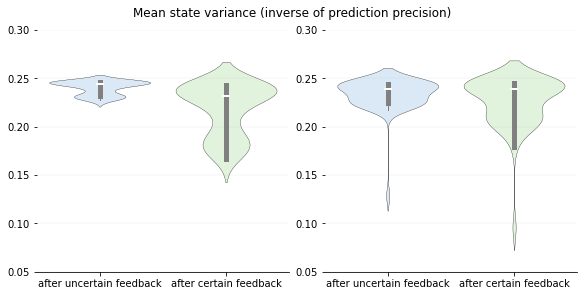

In [11]:
mean_varL_type2 = scipy.io.loadmat(os.path.join(data_path,'stateVariance.mat'))['mean_varL_type2'].T 
mean_varR_type2 = scipy.io.loadmat(os.path.join(data_path,'stateVariance.mat'))['mean_varR_type2'].T 

 # (Nsubj x 2) : 순서는 uncertain, certain

inner_kws=dict(box_width=10, whis_width=1, color="grey")

## Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
sns.violinplot(data=mean_varL_type2, ax=ax1, linewidth=0.3, inner_kws=inner_kws) #, bw_adjest=.2, cut=0)

violins = [c for i, c in enumerate(ax1.collections)]  # 하나 건너 하나 있는 PolyCollection을 가져오기 위해 if i%2 == 0을 사용
[v.set_edgecolor("k") for v in violins]  # 전체 violin edgecolor 변경

violins[0].set_facecolor(tmp_pall_1[0])  
violins[1].set_facecolor(tmp_pall_2[0]) 

# box-whisker: Line2D
ls = [l for i, l in enumerate(ax1.lines)]
[l.set_linewidth(1) for i, l in enumerate(ls) if i%2 == 0] # 전체 box, whisher 굵기 변경
[l.set_linewidth(5) for i, l in enumerate(ls) if i%2 == 1] 

ax1.set_xticklabels(['after uncertain feedback','after certain feedback'])
#ax1.set_yticks([0, 0.6, 1.2, 1.8])
ax1.set_ylim(0.05, 0.3)
ax1.spines[["left", "top", "right"]].set_visible(False)
ax1.grid(axis="y", lw=0.1)
#ax1.set_title("Mean state variance")

ax1.set_xlabel("")
ax1.set_ylabel("")

## Reward
# fig_reward, ax = plt.subplots(figsize=(16, 4), constrained_layout=True)
sns.violinplot(data=mean_varR_type2, ax=ax2, linewidth=0.3, inner_kws=inner_kws)  #, bw_adjest=.2, cut=0)

violins = [c for i, c in enumerate(ax2.collections)]  # 하나 건너 하나 있는 PolyCollection을 가져오기 위해 if i%2 == 0을 사용
[v.set_edgecolor("k") for v in violins]  # 전체 violin edgecolor 변경

violins[0].set_facecolor(tmp_pall_1[0])  
violins[1].set_facecolor(tmp_pall_2[0]) 

# box-whisker: Line2D
ls = [l for i, l in enumerate(ax2.lines)]
[l.set_linewidth(1) for i, l in enumerate(ls) if i%2 == 0] # 전체 box, whisher 굵기 변경
[l.set_linewidth(5) for i, l in enumerate(ls) if i%2 == 1] 

ax2.set_xticklabels(['after uncertain feedback','after certain feedback'])
#ax.set_yticks([0, 0.4, 0.8, 1.2])
ax2.set_ylim(0.05, 0.3)
ax2.spines[["left", "top", "right"]].set_visible(False)
ax2.grid(axis="y", lw=0.1)
#ax2.set_title("Mean state variance (inverse of prediction precision)")

ax2.set_xlabel("")
ax2.set_ylabel("")

fig.suptitle("Mean state variance (inverse of prediction precision)")

pdf_file_path = os.path.join(root_path,'results', 'Figures', 'fig5d.pdf')
with PdfPages(pdf_file_path) as pdf:
    pdf.savefig(fig)

#### Fig. 2b : value trajectory plot

In [ ]:
tmp = scipy.io.loadmat(os.path.join(root_path,'results','behav','loss_result_3o_al.mat'))
GMDP_loss = tmp['GMDP_3o_L1']
tmp = scipy.io.loadmat(os.path.join(root_path,'results','behav','reward_result_4_al.mat'))
GMDP_reward = tmp['GMDP_4_L1']  # (60,1)

tmp_pall_1 = sns.color_palette("Blues")
tmp_pall_2 = sns.color_palette("Greens")

NPE_trial_loss = np.where(loss_ts[:,3])[0]
PPE_trial_loss = np.where(loss_ts[:,0])[0]
NPE_trial_rew = np.where(reward_ts[:,3])[0]
PPE_trial_rew = np.where(reward_ts[:,0])[0]

num_trial = GMDP_reward[30,0]['xn'].shape[1]
Nsubj = GMDP_reward.shape[0]
Nsubj_neuro = Nsubj - 2

Xn_traj = np.zeros([num_trial*2, Nsubj])  # (80, 60)
for si in range(Nsubj):
    for ti in range(num_trial):
        Xn_traj[ti, si] = GMDP_loss[si,0]['xn'][0,ti][0,0][15, 0, 1, 1]
        Xn_traj[ti+num_trial, si] = GMDP_reward[si,0]['xn'][0,ti][0,0][15, 0, 1, 1]

Xn_traj_loss = np.mean(Xn_traj[:num_trial], axis = 1)
Xn_traj_loss = np.concatenate([np.array([0.5]), Xn_traj_loss])
Xn_traj_rew = np.mean(Xn_traj[num_trial:], axis = 1)
Xn_traj_rew = np.concatenate([np.array([0.5]), Xn_traj_rew])

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
sns.lineplot(data = Xn_traj_loss, palette = tmp_pall_1[0])
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylim(-0.1, )
ax.set_xlim(0, )
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
#ax.set_yticklabels("")
ax.grid(axis="y", lw=0.1)
sns.scatterplot(x = NPE_trial_loss+0.5, y = 0, color = tmp_pall_2[3])
sns.scatterplot(x = PPE_trial_loss+0.5, y = 1, color = tmp_pall_2[3])
plt.show()

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
sns.lineplot(data = Xn_traj_rew, palette = tmp_pall_1[0])
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylim(-0.1, )
ax.set_xlim(0, )
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
#ax.set_yticklabels("")
ax.grid(axis="y", lw=0.1)
sns.scatterplot(x = NPE_trial_rew+0.5, y = 0, color = tmp_pall_2[3])
sns.scatterplot(x = PPE_trial_rew+0.5, y = 1, color = tmp_pall_2[3])
plt.show()

In [ ]:
tmp = scipy.io.loadmat(os.path.join(root_path,'results','behav','loss_result_3o_al.mat'))
GMDP_loss = tmp['GMDP_3o_L1']
tmp = scipy.io.loadmat(os.path.join(root_path,'results','behav','reward_result_4_al.mat'))
GMDP_reward = tmp['GMDP_4_L1']  # (60,1)

tmp_pall_1 = sns.color_palette("Blues")
tmp_pall_2 = sns.color_palette("Greens")

NPE_trial_loss = np.where(loss_ts[:,3])[0]
PPE_trial_loss = np.where(loss_ts[:,0])[0]
NPE_trial_rew = np.where(reward_ts[:,3])[0]
PPE_trial_rew = np.where(reward_ts[:,0])[0]

num_trial = GMDP_reward[1,0]['d'].shape[1]
Nsubj = GMDP_reward.shape[0]
Nsubj_neuro = Nsubj - 2

d_traj = np.zeros([Nsubj, num_trial*2])  # (60, 80)
for si in range(Nsubj):
    for ti in range(num_trial):
        d_traj[si, ti] = GMDP_loss[si,0]['d'][0,ti][0,0][0]
        d_traj[si, ti+num_trial] = GMDP_reward[si,0]['d'][0,ti][0,0][0] 

d_traj_loss = np.hstack([np.tile([[0.5]], Nsubj).T, d_traj[:, :num_trial]])   # (60 x 41)
d_traj_rew = np.hstack([np.tile([[0.5]], Nsubj).T, d_traj[:, num_trial:]])

d_traj_tmp = np.squeeze(d_traj_loss.reshape(-1, 1))  # (2460, )
d_traj_loss_df = pd.DataFrame({'value':d_traj_tmp, 
                               'trial':np.tile(np.arange(num_trial+1), Nsubj),   
                               'sub_id':np.repeat(np.arange(Nsubj), num_trial + 1)})
d_traj_tmp = np.squeeze(d_traj_rew.reshape(-1, 1))  # (2460, )
d_traj_rew_df = pd.DataFrame({'value':d_traj_tmp, 
                               'trial':np.tile(np.arange(num_trial+1), Nsubj),   
                               'sub_id':np.repeat(np.arange(Nsubj), num_trial + 1)})

fig1, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
sns.lineplot(data = np.mean(d_traj_loss, axis = 0), palette = tmp_pall_1[0])
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylim(-0.1, )
ax.set_xlim(0, )
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
ax.set_title('Loss task')
#ax.set_yticklabels("")
ax.grid(axis="y", lw=0.1)
sns.scatterplot(x = NPE_trial_loss+0.5, y = 0, color = tmp_pall_2[3])
sns.scatterplot(x = PPE_trial_loss+0.5, y = 1, color = tmp_pall_2[3])
#plt.show()

fig2, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
sns.lineplot(data = np.mean(d_traj_rew, axis = 0), palette = tmp_pall_1[0])
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylim(-0.1, )
ax.set_xlim(0, )
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
ax.set_title('Reward task')
#ax.set_yticklabels("")
ax.grid(axis="y", lw=0.1)
sns.scatterplot(x = NPE_trial_rew+0.5, y = 0, color = tmp_pall_2[3])
sns.scatterplot(x = PPE_trial_rew+0.5, y = 1, color = tmp_pall_2[3])

##
fig3, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
sns.lineplot(data = d_traj_loss_df, x = 'trial', y = 'value', ci='sd', palette = tmp_pall_1[0])
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylim(-0.1, )
ax.set_xlim(0, )
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
ax.set_title('Loss task')
#ax.set_yticklabels("")
ax.grid(axis="y", lw=0.1)
sns.scatterplot(x = NPE_trial_loss+0.5, y = 0, color = tmp_pall_2[3])
sns.scatterplot(x = PPE_trial_loss+0.5, y = 1, color = tmp_pall_2[3])
#plt.show()

fig4, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
sns.lineplot(data = d_traj_rew_df, x = 'trial', y = 'value', ci='sd', palette = tmp_pall_1[0])
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylim(-0.1, )
ax.set_xlim(0, )
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
ax.set_title('Reward task')
#ax.set_yticklabels("")
ax.grid(axis="y", lw=0.1)
sns.scatterplot(x = NPE_trial_rew+0.5, y = 0, color = tmp_pall_2[3])
sns.scatterplot(x = PPE_trial_rew+0.5, y = 1, color = tmp_pall_2[3])
#plt.show()
pdf_file_path = os.path.join(root_path,'results','Figures','fig2b_sub.pdf')
with PdfPages(pdf_file_path) as pdf:     
    pdf.savefig(fig1)
    pdf.savefig(fig2)   
    pdf.savefig(fig3)
    pdf.savefig(fig4)

#### Fig. 6b : Comparison of UC, C feedback
###### code of Fig. 6c is included in anova_rm.ipynb, AIF_signal_save.m, group_comp.m

9
54 2
(1, 2)
(2,)
(9, 9, 2)
2
fig_pair1_0
fig_pair1_1


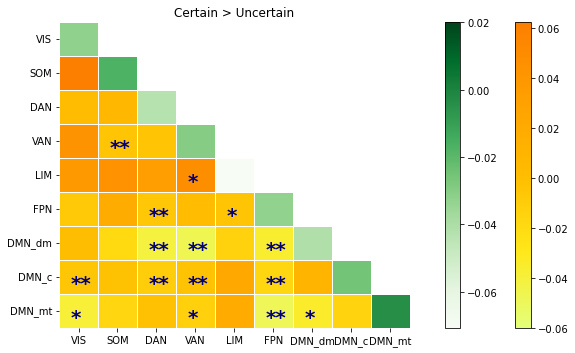

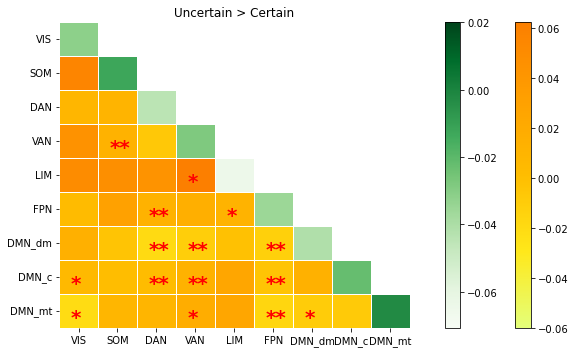

In [10]:
# After performing twosamlettest.m
model_idx = 5
DMN = 1
if DMN == 1:
    net = ['VIS','SOM','DAN', 'VAN', 'LIM', 'FPN', 'DMN_dm', 'DMN_c', 'DMN_mt']
else:
    net = ['VIS','SOM','DAN', 'VAN', 'LIM', 'FPN', 'DMN']
Nnet = len(net)
print(Nnet)
tmp = scipy.io.loadmat(os.path.join(root_path, "results", "graph_met", "bct_metric_DS" + "{0:02d}".format(model_idx) + ".mat"))
try:
    inter_whole = tmp['inter_whole'][0]
    inter_whole_mean = tmp['inter_whole_mean'][0]
    Nsubj = inter_whole[0].shape[2]
    Nnet = inter_whole[0].shape[1]
    Nvar = inter_whole.shape[0]
except:
    if DMN == 1:
        inter_whole = scipy.io.loadmat(os.path.join(root_path, "results", "GLM", "act_system_dmn_DS" + "{0:02d}".format(model_idx) + ".mat"))['params_mass'] # (28 x Nsubj x num_var)
    else:
        inter_whole = scipy.io.loadmat(os.path.join(root_path, "results", "GLM", "act_system_DS" + "{0:02d}".format(model_idx) + ".mat"))['params_mass'] # (28 x Nsubj x num_var)
    inter_whole_mean = np.mean(inter_whole, axis = 1)
    Nsubj = inter_whole.shape[1]
    Nvar = inter_whole.shape[2]
    sig_rt_mat = np.zeros((Nnet, Nnet, Nvar))
    ii = 0
    for ni in range(Nnet):
        sig_rt_mat[ni, ni:Nnet, :] = inter_whole_mean[ii:(ii+Nnet-ni), :]
        ii = ii + Nnet - ni
    
    if model_idx == 6:
        var_idx = [2, 3, 4]
    elif model_idx == 5:
        var_idx = [2, 3]
    
    inter_whole_mean = list()
    for vi in var_idx:
        inter_whole_mean.append(sig_rt_mat[:,:,vi])
    
    Nvar = len(var_idx)

if DMN == 1:
    H_whole = tmp['H_whole_dmn']
    H_whole_cor = tmp['H_whole_cor_dmn']
else:
    H_whole = tmp['H_whole']
    H_whole_cor = tmp['H_whole_cor']
  
print(Nsubj, Nvar)
print(H_whole.shape)  # (compar, 2(rt&lt))
print(H_whole[0].shape)
print(H_whole[0][0].shape)
print(len(inter_whole_mean)) # == len(ft_name)

compar = H_whole.shape[0]
if compar == 1:
    x1_idx = [[0,1]]
    ft_name = ['Certain', 'Uncertain']

elif compar == 3:
    x1_idx = [[0,1], [0,2], [1,2]]
    ft_name = ['Certain', 'Uncertain', 'Uncertain2']

cbar_max_inter = np.zeros((Nvar,1))
cbar_min_inter = np.zeros((Nvar,1))
cbar_max_intra = np.zeros((Nvar,1))
cbar_min_intra = np.zeros((Nvar,1))
for vi in range(Nvar):
    plot_data = inter_whole_mean[vi]
    plot_data = plot_data[:Nnet, :Nnet]
    diag_tmp = np.eye(Nnet, Nnet) * np.sum(np.triu(plot_data, 1))/np.where(np.triu(plot_data, 1))[0].shape[0]
    plot_data_inter = diag_tmp + np.triu(plot_data, 1) + np.tril(plot_data, -1)
    diag_tmp = np.eye(Nnet, Nnet) * np.diag(plot_data)
    plot_data_intra = diag_tmp + (np.ones(Nnet) - np.eye(Nnet, Nnet)) * np.mean(np.diag(plot_data))
    cbar_max_inter[vi] = np.max(plot_data_inter)
    cbar_min_inter[vi] = np.min(plot_data_inter)
    cbar_max_intra[vi] = np.max(plot_data_intra)
    cbar_min_intra[vi] = np.min(plot_data_intra)

annot_template = np.repeat(np.expand_dims(np.tile(np.array(['  ']), Nnet), axis = 1),  Nnet, axis = 1)
annot_rt = list()
annot_lt = list()
for ci in range(compar):
    x1_idx_tmp = x1_idx[ci]
    for vi in x1_idx_tmp:
        annot_tmp = annot_template.copy()
        annot_tmp[np.where(H_whole[ci][0][:Nnet, :Nnet, x1_idx_tmp.index(vi)])] = '*'
        annot_tmp[np.where(H_whole_cor[ci][0][:Nnet, :Nnet, x1_idx_tmp.index(vi)])] = '**'
        annot_rt.append(annot_tmp)
        annot_tmp = annot_template.copy()
        annot_tmp[np.where(H_whole[ci][1][:Nnet, :Nnet, x1_idx_tmp.index(vi)])] = '*'
        annot_tmp[np.where(H_whole_cor[ci][1][:Nnet, :Nnet, x1_idx_tmp.index(vi)])] = '**'
        annot_lt.append(annot_tmp)

for ci in range(compar):
    x1_idx_tmp = x1_idx[ci]
    for vi in x1_idx_tmp:
        plot_data_inter = inter_whole_mean[vi]
        plot_data_inter = plot_data_inter[:Nnet, :Nnet]
        diag_tmp = np.eye(Nnet, Nnet) * np.sum(np.triu(plot_data_inter, 1))/np.where(np.triu(plot_data_inter, 1))[0].shape[0]
        plot_data_inter = diag_tmp + np.triu(plot_data_inter, 1).T + np.triu(plot_data_inter, 1)
        
        # Create a mask to separate the diagonal elements
        mask = np.zeros_like(plot_data_inter, dtype=bool)
        mask[np.diag_indices_from(mask)] = True
        
        plot_data_inter[np.where(np.triu(np.ones(Nnet), 1))] = np.NaN
        # Inter (uper triangle)
        print('fig_pair' + str(ci+1) + '_' + str(vi))
        if Nnet == 9:
            globals()['fig_pair' + str(ci+1) + '_' + str(vi)], ax = plt.subplots(figsize=(8, 4.8), constrained_layout=True)  # figsize=(3, 3.5)
        else:
            globals()['fig_pair' + str(ci+1) + '_' + str(vi)], ax = plt.subplots(figsize=(6, 4.3), constrained_layout=True)  # figsize=(3, 3.5)
        sns.heatmap(data=plot_data_inter, mask=mask, cmap="Wistia", annot = False, fmt="", 
                    annot_kws={'size':30, 'fontweight':'bold'}, linewidths=.5, cbar=False, ax=ax, xticklabels=net, yticklabels=net, 
                    vmin=-0.06, vmax=np.min(cbar_max_inter))
        # Intra (diagonal)
        plot_data_intra = inter_whole_mean[vi]
        plot_data_intra = plot_data_intra[:Nnet, :Nnet]
        diag_tmp = np.eye(Nnet, Nnet) * np.diag(plot_data_intra)
        plot_data_intra = diag_tmp + (np.ones(Nnet) - np.eye(Nnet, Nnet)) * np.mean(np.diag(plot_data_intra))
        sns.heatmap(data=plot_data_intra, mask=~mask, cmap="Greens", annot = False, fmt="", 
                    annot_kws={'size':30, 'fontweight':'bold'}, linewidths=.5, cbar=False, ax=ax, xticklabels=net, yticklabels=net, 
                    vmin=np.min(cbar_min_intra), vmax=0.02)
        for i in range(Nnet):
            for j in range(Nnet):
                plt.text(j + 0.3, i + 0.85, annot_rt[int(ci*2 + x1_idx_tmp.index(vi))][j, i], {'fontsize':20, 'color':'red', 'weight':'bold'})
                plt.text(j + 0.3, i + 0.85, annot_lt[int(ci*2 + x1_idx_tmp.index(vi))][j, i], {'fontsize':20, 'color':'navy', 'weight':'bold'})   
        # add colorbar
        cbar1 = ax.figure.colorbar(ax.collections[0], ax=ax, orientation="vertical", pad=0.05)
        cbar2 = ax.figure.colorbar(ax.collections[1], ax=ax, orientation="vertical", pad=0.1)
        plt.title(ft_name[vi] + ' > ' + ft_name[x1_idx_tmp[1 - x1_idx_tmp.index(vi)]])
        #plt.show()

if DMN == 1:
    pdf_file_path = os.path.join(root_path,'results','Figures','fig6b_DS'+ '{0:02d}'.format(model_idx) +'_dmn.pdf')
else:
    pdf_file_path = os.path.join(root_path,'results','Figures','fig6b_DS'+ '{0:02d}'.format(model_idx) +'.pdf')
with PdfPages(pdf_file_path) as pdf:
    for ci in range(compar):
        x1_idx_tmp = x1_idx[ci]
        for vi in x1_idx_tmp:
            pdf.savefig(globals()['fig_pair' + str(ci+1) + '_' + str(vi)])

##### 